### Introducción a la materia Aprendizaje Automático

**Un juego**

Un amigo entrañable, Alex, se fue a vivir a EEUU hace unos años. Hace un rato mandó mensajito de WhatsApp, después de un par de meses sin tener noticias. Nos contó que había conseguido un trabajo muy bien pago en una inmobiliaria en San Francisco, California.  Claro que para hacerlo, había tenido que poner en su CV que era "Data Scientists". Alex nos explica que es lo que está haciendo todo el mundo, porque piden Data Scientists por doquier. Pero en realidad su formación en estadística y análisis de datos se limita a un par de videos de YouTube, y a un cursito de Coursera, que dejó por la mitad. 

El primer lunes en la oficina, nos cuenta Alex, su jefe llega, exultante, y le cuenta lo satisfecho que está de iniciar su departamento de Data Science en la Inmobiliaria, y le pasa la clave para acceder a los archivos de la empresa, que contiene información de las propiedades que tiene en su haber la inmobiliaria. Y le pide que los use para "mejorar la eficiencia y ganancia de la inmobiliaria". Le pide algún resultado para el final de la semana.

Alex está en pánico, pero vio el tuit que vos había escrito, diciendo que arrancabas la materia de Aprendizaje Automático de UNSAM, y pensó que tal vez podés darle una mano para salir de este brete. Promete conectarse como oyente a las clases de ahora en más. Antes de esperar la respuesta, manda los datos y un gif simpático.

Vamos a ver cómo podemos ayudarlo, pobre Alex.

**Plan**

1) Visualizar los datos para obtener alguna idea de qué pregunta podrían llegar a responder.

2) Definir el proyecto.

3) Preparar los datos.

4) Correr algún modelo simple simple (¿tal vez el jueves?)



2) See residuals as a function of same categorical variables, such as ocean_proximity (ver notebook R).

3) Feature selection? Ir sacando features y mirando p-values o algo.

# Preparación

Antes que nada, corramos algunas celdas de código para prepararnos. Mucho de lo que viene a continuación está sacado del libro de Aurélien Geron, y su [repo de GitHub](https://github.com/ageron/handson-ml2), que recomendamos.

In [9]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "01_Intro"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Obtención de los datos

Lo primero es obtener los datos que manda Alex. Para eso, definimos una variable extra, con la ubicación del archivo

In [10]:
HOUSING_PATH = os.path.join(".", "datasets", "housing")

Si están corriendo esto en Colab, tienen que bajar los datos del repositorio y copiarlo a su directorio en la nube. Esto se hace con el código de la siguiente celda

In [11]:
assert 'google.colab' in sys.modules, "Ojo! No estás corriendo en Colab. No hace falta esto."
    
import tarfile

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/IAI-UNSAM/ML_UNSAM/master/"
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

!mkdir -p ./datasets/housing

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    #urllib.request.urlretrieve(housing_url, tgz_path)
    !wget https://raw.githubusercontent.com/IAI-UNSAM/ML_UNSAM/master/datasets/housing/housing.tgz -P {housing_path}
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
# Corramos la función
fetch_housing_data()

AssertionError: Ojo! No estás corriendo en Colab. No hace falta esto.

In [12]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [13]:
#Cargemos los datos y veamos las primeras filas
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


> Yo: "Alex, ¿qué es esto? Tirame alguna pista adicional."
>
> Alex: "Son datos por distrito. Cada columna representa un distrito diferente en California."
>
> Yo: "Algo más?"
>
> Alex: ...
> 
> Yo: "Las unidades de cada columna?"
>
> Alex: ...

Creo que se dice "nos clavó el visto".

Bueno, por suerte el paquete `pandas` tiene cosas útiles. Usemos el método <tt>info</tt> para tener más información.

In [14]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Vemos que tenemos 20640 registros (distritos), con 10 columnas para cada uno.

La mayoría de esas columnas son numéricas, pero hay una que tiene otro tipo de objetos (ya lo vimos arriba).

`ocean_proximity` es intrigante. Veamos más de cerca. ¿Qué valores toma?

In [36]:
housing["ocean_proximity"].unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

Ok, vemos que es lo que se llama una variable categórica. Hay solo cinco posibles valores para esa variable. Veamos cuantos distritos en cada uno.

***

**Preguntas**

1) ¿Qué preguntas creen que pueden responder estos datos?

2) ¿Cómo haríamos para empezar a responder esa pregunta?

3) ¿Qué variables parecen las más relevantes?

## Criterio de evaluación.

Una vez que tenemos una idea clara de los objetivos, lo primero que tenemos que hacer es decidir qué criterio de evaluación vamos a usar.

***

**Preguntas**

1) ¿Cómo podemos saber si nuestro modelo funciona?

2) ¿Cómo podemos cuantíficar cuán bien funciona?

3) ¿Cómo garantizamos que la predicción va a funcionar cuando aparezcan nuevas casas para evaluar?

## Exploración de los datos

Tal vez lo primero que a uno se le puede ocurrir es calcular promedios y cosas de los datos.

In [33]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Vean que `ocean_proximity` no aparece en esta tabla, porque no es numérica. Y volvemos a ver que faltan algunas entrdas en `total_bedrooms`.

***
**Pregunta**: ¿Se les ocurre que podemos hacer con los registros que faltan de `total_bedrooms`?
***
Otra buena idea es hacer un plot de los gráficos. Como tenemos latitud y longitud, se impone graficar eso.

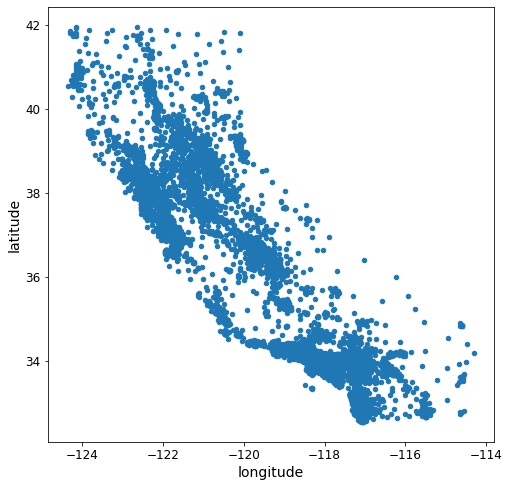

In [45]:
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(8, 8))
# save_fig("bad_visualization_plot")

Mmmm, no se ve nada, no? Aunque se adivina la forma de California.

<p><a href="https://commons.wikimedia.org/wiki/File:Map_of_California_NA-2004-compact.png#/media/File:Map_of_California_NA-2004-compact.png"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/78/Map_of_California_NA-2004-compact.png/1200px-Map_of_California_NA-2004-compact.png" alt="Map of California NA-2004-compact.png" style="width:400px; align:left"></a></p>

Podemos agregar algo de claridad haciendo que los puntos sean transparentes.

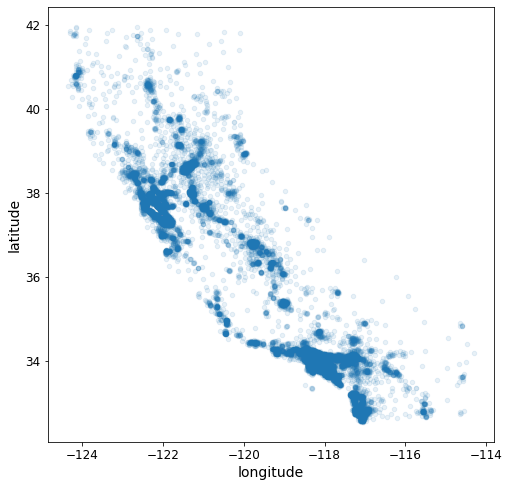

In [49]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1, figsize=(8, 8))
# save_fig("better_visualization_plot")

Ahora podemos ver que hay zonas más pobladas y otras menos pobladas, por ejemplo.

Por último agreguemos otras variables como tamaño de los símbolos y color.

*** 

*Pregunta*

1) ¿Qué variable agregarían?

----